In [106]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torchbnn as bnn

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats
import seaborn as sns

### Variational Inference

In [107]:
df = pd.read_csv("GlobalWeatherRepository.csv")

features = ["humidity", "wind_kph", "pressure_mb", "precip_mm", "cloud", "visibility_km", "uv_index"]
target = "temperature_celsius"

df = df.dropna(subset=features + [target])

X = df[features].values
y = df[target].values.reshape(-1, 1)

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X = scaler_x.fit_transform(X)
y = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24520800)
torch.manual_seed(24520800)
np.random.seed(24520800)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [108]:
model_vi = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=len(features), out_features=128),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=128, out_features=64),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=64, out_features=1),
)

kl_loss = bnn.BKLLoss(reduction="mean")
optimizer = torch.optim.Adam(model_vi.parameters(), lr=0.01)

kl_weight = 0.01

In [109]:
def gaussian_nll(y, y_hat, sigma=1.0):
    return 0.5 * torch.mean((y - y_hat)**2 / sigma**2)

In [110]:
def gaussian_nll_forward_backward(y, y_hat, sigma=1.0):
    N = y.shape[0]

    # forward
    residual = y_hat - y  # (N,1)
    loss = 0.5 * torch.mean(residual**2) / sigma**2

    # backward (dL/dy_hat)
    grad_y_hat = residual / (N * sigma**2)  # (N,1)

    return loss, grad_y_hat

In [111]:
epochs = 1000
history_loss = []

for epoch in range(epochs):
    pred = model_vi(X_train)
    nll, grad_pred = gaussian_nll_forward_backward(y_train, pred)
    kl = kl_loss(model_vi)
    loss = nll + kl_weight * kl

    optimizer.zero_grad()
    (kl * kl_weight).backward(retain_graph=True)
    pred.backward(grad_pred)
    optimizer.step()

    history_loss.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Total Loss: {loss.item():.4f} | NLL: {nll.item():.4f}")

Epoch 0 | Total Loss: 0.5943 | NLL: 0.5907
Epoch 100 | Total Loss: 0.2755 | NLL: 0.2701
Epoch 200 | Total Loss: 0.2893 | NLL: 0.2834
Epoch 300 | Total Loss: 0.2435 | NLL: 0.2374
Epoch 400 | Total Loss: 0.2378 | NLL: 0.2317
Epoch 500 | Total Loss: 0.2226 | NLL: 0.2161
Epoch 600 | Total Loss: 0.2309 | NLL: 0.2239
Epoch 700 | Total Loss: 0.2194 | NLL: 0.2126
Epoch 800 | Total Loss: 0.2132 | NLL: 0.2064
Epoch 900 | Total Loss: 0.2177 | NLL: 0.2109


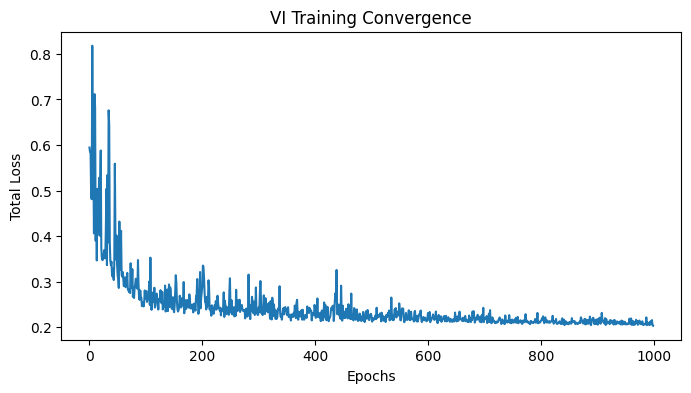

In [112]:
plt.figure(figsize=(8, 4))
plt.plot(history_loss)
plt.title("VI Training Convergence")
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.show()

In [113]:
# Predictive Inference
model_vi.eval()
samples = 100
preds = []

with torch.no_grad():
    for i in range(samples):
        # Each pass samples different weights from the learned distribution
        preds.append(model_vi(X_test).numpy().flatten())

# Calculate Mean and Std Dev
preds = np.array(preds)
mean_vi = preds.mean(axis=0)
std_vi  = preds.std(axis=0)

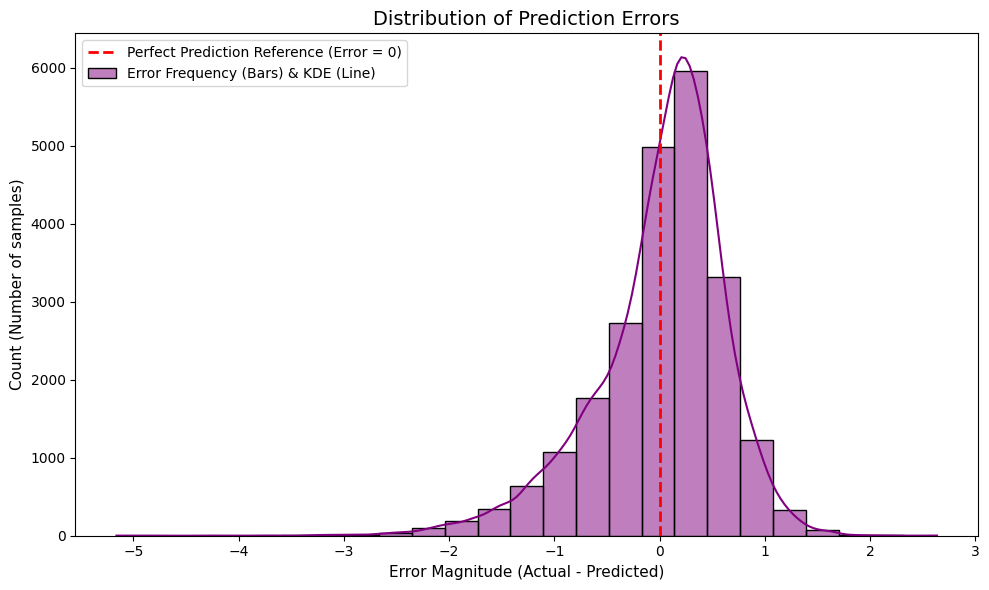

In [114]:
y_actual = y_test.numpy().flatten()
y_predicted = mean_vi
residuals = y_actual - y_predicted
# Trích xuất tham số từ mô hình VI của bạn (tên biến có thể là mu/log_sigma tùy code của bạn)

plt.figure(figsize=(10, 6))

sns.histplot(residuals, kde=True, color='purple', bins=25,
             label='Error Frequency (Bars) & KDE (Line)')

plt.axvline(0, color='red', linestyle='--', linewidth=2,
            label='Perfect Prediction Reference (Error = 0)')

plt.title('Distribution of Prediction Errors', fontsize=14)
plt.xlabel('Error Magnitude (Actual - Predicted)', fontsize=11)
plt.ylabel('Count (Number of samples)', fontsize=11)

plt.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

In [115]:
mu_tensors = []
logsigma_tensors = []
for m in model_vi:
    if isinstance(m, bnn.BayesLinear):
        weight_mu = None
        weight_logsigma = None
        # Inspect named_parameters for common naming conventions
        for pname, p in m.named_parameters():
            lname = pname.lower()
            if ('mu' in lname or 'mean' in lname or 'loc' in lname) and 'log' not in lname and 'rho' not in lname:
                weight_mu = p.detach().flatten()
            if ('rho' in lname or 'log' in lname or 'sigma' in lname or 'std' in lname):
                weight_logsigma = p.detach().flatten()
        # Fallback: take any 'weight' parameter as the mean if no explicit mean found
        if weight_mu is None:
            for pname, p in m.named_parameters():
                if 'weight' in pname.lower():
                    weight_mu = p.detach().flatten()
                    break
        # If still missing, create a zero-mean fallback (shouldn't normally happen)
        if weight_mu is None:
            weight_mu = torch.zeros(sum(p.numel() for _, p in m.named_parameters()))
        # If no explicit log-sigma/rho parameter, fallback to a small fixed uncertainty
        if weight_logsigma is None:
            weight_logsigma = torch.full_like(weight_mu, -6.0)
        mu_tensors.append(weight_mu.cpu())
        logsigma_tensors.append(weight_logsigma.cpu())
if len(mu_tensors) == 0:
    raise RuntimeError('No BayesLinear layers found in model_vi')
mu_all = torch.cat(mu_tensors).numpy()
log_sigma_all = torch.cat(logsigma_tensors).numpy()
# Use same parameter index as MCMC (fallback to 0 if undefined)
weight_idx = param_index if 'param_index' in globals() else 0
mu_val = mu_all[weight_idx]
sigma_val = np.exp(log_sigma_all[weight_idx])
vi_samples = np.random.normal(mu_val, sigma_val, size=2000)

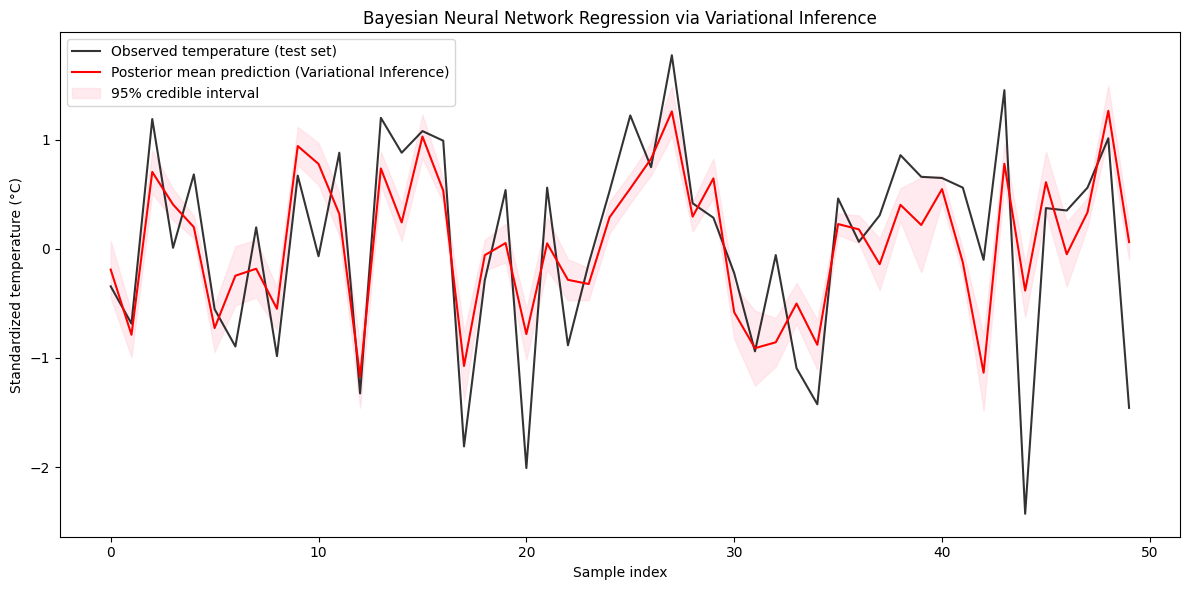

In [116]:
plt.figure(figsize=(12, 6))

plt.plot(
    y_test[:50].numpy(),
    color="black",
    label="Observed temperature (test set)",
    alpha=0.8
)

plt.plot(
    mean_vi[:50],
    color="red",
    label="Posterior mean prediction (Variational Inference)"
)

plt.fill_between(
    range(50),
    mean_vi[:50] - 2 * std_vi[:50],
    mean_vi[:50] + 2 * std_vi[:50],
    color="pink",
    alpha=0.3,
    label="95% credible interval"
)

plt.xlabel("Sample index")
plt.ylabel("Standardized temperature (°C)")
plt.title("Bayesian Neural Network Regression via Variational Inference")

plt.legend()
plt.tight_layout()
plt.show()

### MCMC

In [117]:
# Define Bayesian (Stochastic Function)
class SimpleBNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x).squeeze()

In [118]:
def gaussian_loglikelihood_grad(y, preds, noise_std=1.0):
    return (y - preds) / (noise_std**2)

In [119]:
def log_prior(model, prior_std=1.0):
    log_p = 0.0
    for p in model.parameters():
        log_p += -0.5 * torch.sum(p**2) / prior_std**2
    return log_p

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def langevin_sampler_gpu(model, X_train, y_train, X_test, y_test, step_size=5e-6, n_steps=35000):
    # Chuyển toàn bộ mô hình và dữ liệu lên GPU ngay từ đầu
    model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    samples = []
    param_traces = []
    train_lp_history = []
    test_lp_history = []
    tau_history = []

    alpha_0, beta_0 = 1.0, 1.0
    tau = torch.tensor(1.0).to(device) # Tau cũng cần ở trên GPU
    prior_std = 1.0
    n_train = y_train.shape[0]

    for step in range(n_steps):
        model.train()
        #Xóa sạch bảng nháp Gradient cũ.
        model.zero_grad() 
        
        # --- Tính Log Posterior ---
        preds_train = model(X_train)
        log_lik = 0.5 * n_train * torch.log(tau) - 0.5 * tau * torch.sum((y_train - preds_train)**2)
        log_p_weights = sum(-0.5 * (1/prior_std**2) * torch.sum(p**2) for p in model.parameters())
        lp_train = log_lik + log_p_weights
        
        lp_train.backward() 

        # --- SGLD Update 
        with torch.no_grad():# Tạm dừng tính đạo hàm để cập nhật trọng số
            for p in model.parameters():
                noise = torch.randn_like(p) * np.sqrt(step_size) # Random tạo trực tiếp trên GPU
                p.add_(p.grad, alpha=0.5 * step_size) 
                p.add_(noise)

        # --- Cập nhật Tau (Gamma Bayes) ---
        with torch.no_grad():
            mse_train = torch.sum((y_train - model(X_train))**2)
            alpha_n = alpha_0 + n_train / 2.0
            beta_n = beta_0 + 0.5 * mse_train
            
            tau_val = np.random.gamma(alpha_n, 1.0/beta_n.item()) 
            tau = torch.tensor(tau_val, dtype=torch.float32).to(device)

        if step % 10 == 0: # Chỉ lưu mỗi 10 bước để tiết kiệm bộ nhớ nếu cần
            train_lp_history.append(lp_train.item())
            tau_history.append(tau.item())
            
            with torch.no_grad():
                preds_test = model(X_test)
                lp_test = 0.5 * y_test.shape[0] * torch.log(tau) - 0.5 * tau * torch.sum((y_test - preds_test)**2) + log_p_weights
                test_lp_history.append(lp_test.item())
            
            current_params = torch.cat([p.detach().flatten() for p in model.parameters()])
            param_traces.append(current_params.cpu().numpy())
            samples.append([p.detach().clone().cpu() for p in model.parameters()])

        if step % 5000 == 0:
            print(f"Step {step} | Train LP: {lp_train.item():.2f} | Tau: {tau.item():.2f}")

    return samples, np.array(param_traces), train_lp_history, test_lp_history, tau_history


In [121]:
X_mcmc = X_train[:200]
y_mcmc = y_train[:200].squeeze()

model_mcmc = SimpleBNN(X_mcmc.shape[1])
samples, param_traces, train_lp, test_lp, tau_trace = langevin_sampler_gpu(model_mcmc, X_mcmc, y_mcmc, X_test, y_test)
param_samples = np.array(param_traces)

Step 0 | Train LP: -126.29 | Tau: 0.75
Step 5000 | Train LP: -51.99 | Tau: 1.66
Step 10000 | Train LP: -44.88 | Tau: 2.12
Step 15000 | Train LP: -38.40 | Tau: 2.10
Step 20000 | Train LP: -39.80 | Tau: 1.80
Step 25000 | Train LP: -32.98 | Tau: 2.18
Step 30000 | Train LP: -34.93 | Tau: 2.30


In [122]:
def predict_from_samples(model, samples, X):
    model.eval() # Chuyển sang chế độ eval (tắt dropout nếu có)
    preds = []
    
    # Xác định thiết bị hiện tại của model (GPU hay CPU)
    device = next(model.parameters()).device
    # Đảm bảo dữ liệu đầu vào X phải cùng thiết bị với model
    X = X.to(device)

    for s in samples:
        with torch.no_grad():
            # s là danh sách các trọng số đã lưu, zip nó với parameters của model
            for p, sp in zip(model.parameters(), s):
                # sp đã được lưu bằng .cpu() ở hàm sampler trước đó, 
                # nên cần đưa lại lên device của model trước khi copy_
                p.copy_(sp.to(device))
            
            # Dự báo và đẩy kết quả về cpu rồi mới chuyển sang numpy
            out = model(X)
            preds.append(out.cpu().numpy())

    return np.array(preds)
preds_mcmc = predict_from_samples(model_mcmc, samples, X_mcmc)

mean_mcmc = preds_mcmc.mean(axis=0)
std_mcmc  = preds_mcmc.std(axis=0)


In [123]:
burn_in = int(2200)
param_index = min(120, param_samples.shape[1] - 1)

trace = param_samples[:, param_index]
burn_in_trace = trace[:burn_in]
posterior_trace = trace[burn_in:]

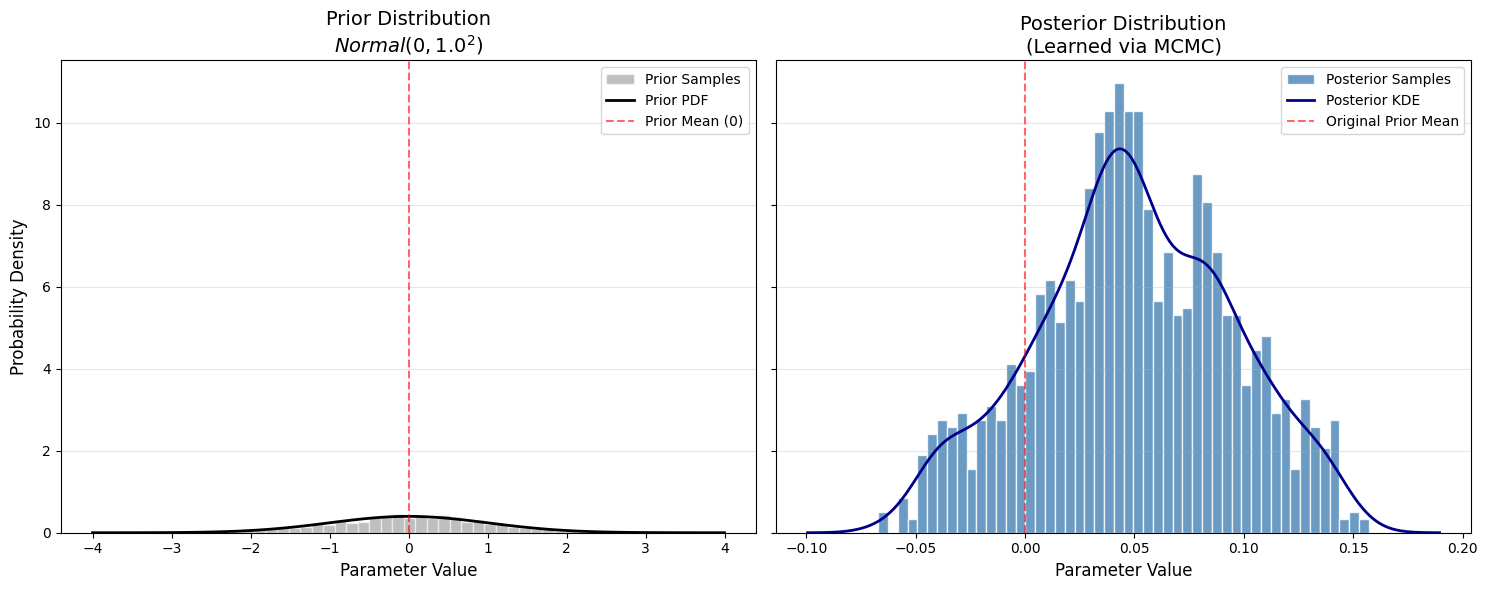

In [124]:
prior_std = 1.0

posterior_samples = param_samples[burn_in:, param_index]

prior_samples = np.random.normal(0, prior_std, size=len(posterior_samples))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

# prior
ax1.hist(prior_samples, bins=50, density=True, color='gray', alpha=0.5, edgecolor='white', label='Prior Samples')

x_prior = np.linspace(-4, 4, 100)
ax1.plot(x_prior, stats.norm.pdf(x_prior, 0, prior_std), color='black', lw=2, label='Prior PDF')
ax1.axvline(0, color='red', linestyle='--', alpha=0.6, label='Prior Mean (0)')

ax1.set_title(f'Prior Distribution\n$Normal(0, {prior_std}^2)$', fontsize=14)
ax1.set_xlabel('Parameter Value', fontsize=12)
ax1.set_ylabel('Probability Density', fontsize=12)
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# posterior
ax2.hist(posterior_samples, bins=50, density=True, color='steelblue', alpha=0.8, edgecolor='white', label='Posterior Samples')

sns.kdeplot(posterior_samples, ax=ax2, color='darkblue', linewidth=2, label='Posterior KDE')

ax2.axvline(0, color='red', linestyle='--', alpha=0.6, label='Original Prior Mean')

ax2.set_title(f'Posterior Distribution\n(Learned via MCMC)', fontsize=14)
ax2.set_xlabel('Parameter Value', fontsize=12)
ax2.legend(loc='upper right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

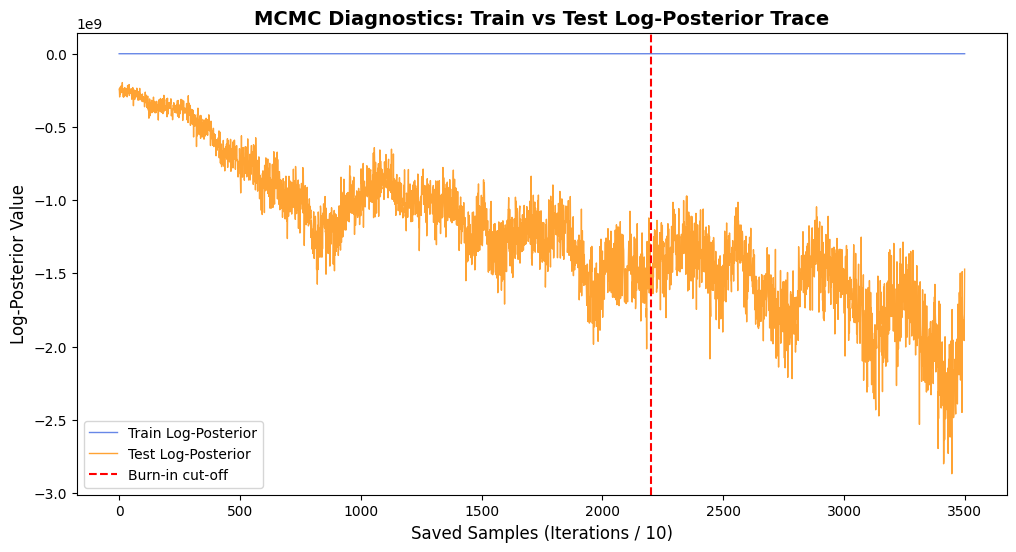

In [125]:
plt.figure(figsize=(12, 6))

# Sửa 'train_lp_history' thành 'train_lp'
plt.plot(train_lp, label='Train Log-Posterior', color='royalblue', alpha=0.8, linewidth=1)

# Sửa 'test_lp_history' thành 'test_lp'
plt.plot(test_lp, label='Test Log-Posterior', color='darkorange', alpha=0.8, linewidth=1)

burn_in_mark =2200
plt.axvline(x=burn_in_mark, color='red', linestyle='--', label=f'Burn-in cut-off')

plt.title('MCMC Diagnostics: Train vs Test Log-Posterior Trace', fontsize=14, fontweight='bold')
plt.xlabel('Saved Samples (Iterations / 10)', fontsize=12)
plt.ylabel('Log-Posterior Value', fontsize=12)
plt.legend()
plt.show()

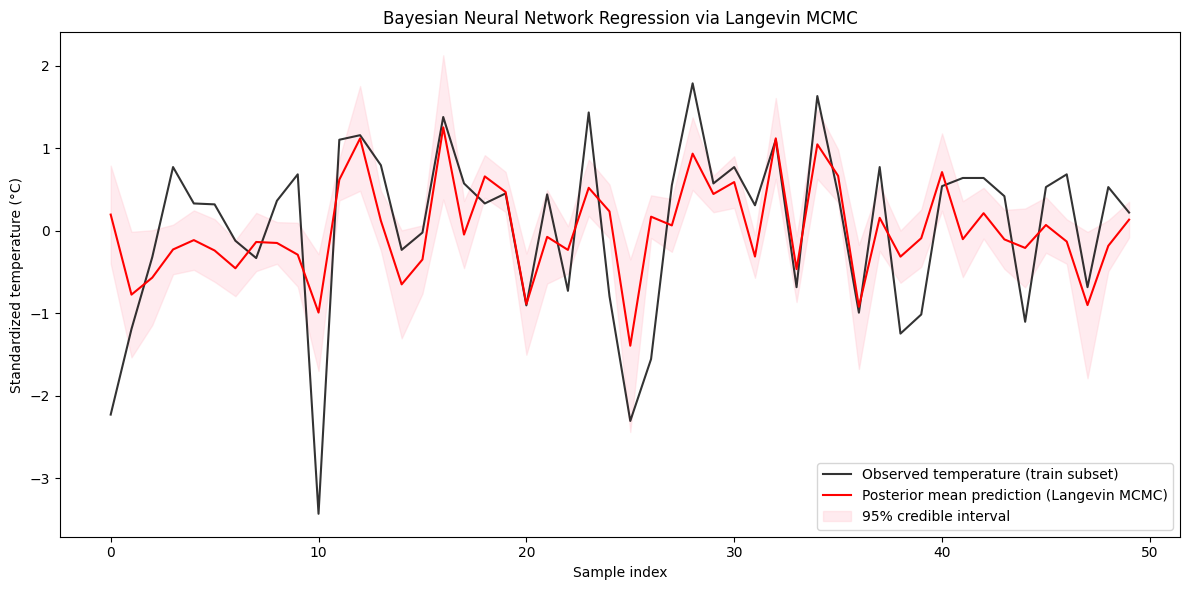

In [126]:
plt.figure(figsize=(12, 6))

plt.plot(
    y_mcmc[:50].numpy(),
    color="black",
    label="Observed temperature (train subset)",
    alpha=0.8
)

plt.plot(
    mean_mcmc[:50],
    color="red",
    label="Posterior mean prediction (Langevin MCMC)"
)

plt.fill_between(
    range(50),
    mean_mcmc[:50] - 2 * std_mcmc[:50],
    mean_mcmc[:50] + 2 * std_mcmc[:50],
    color="pink",
    alpha=0.3,
    label="95% credible interval"
)

plt.xlabel("Sample index")
plt.ylabel("Standardized temperature (°C)")
plt.title("Bayesian Neural Network Regression via Langevin MCMC")

plt.legend()
plt.tight_layout()
plt.show()

### Performance Comparison

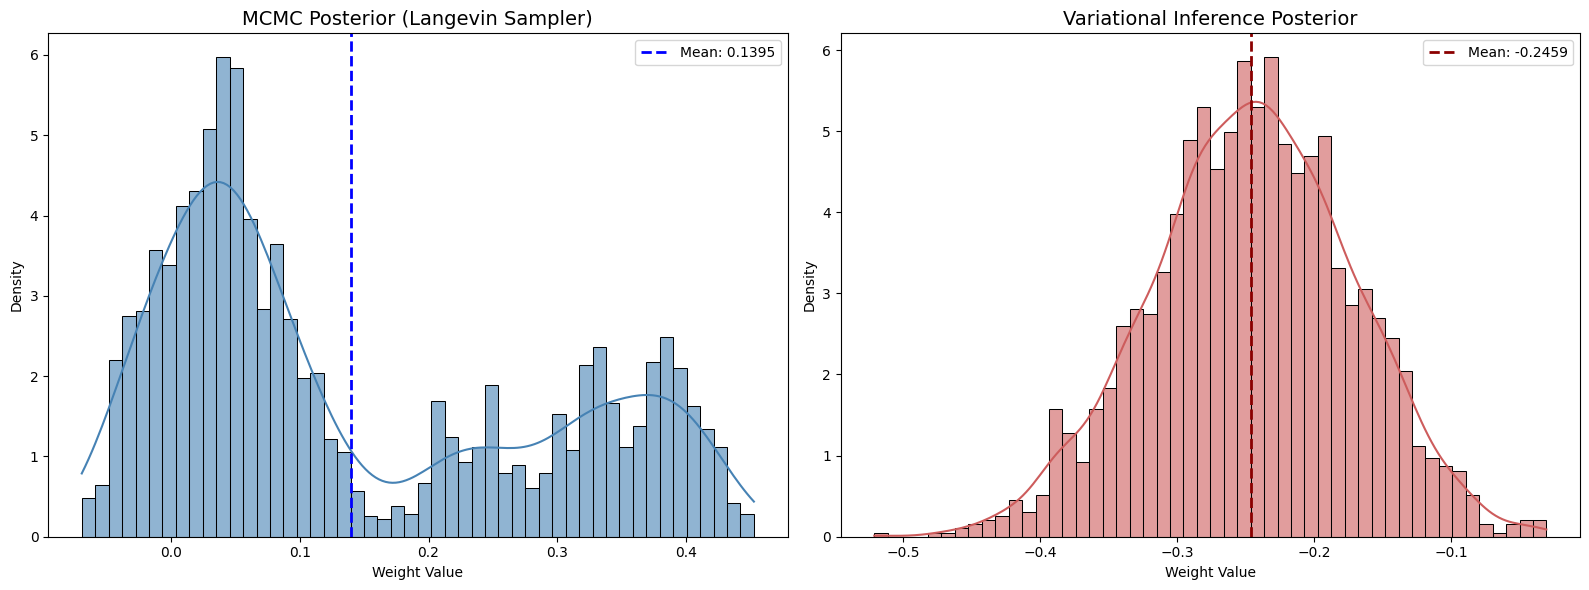

In [127]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- BIỂU ĐỒ 1: MCMC POSTERIOR ---
burn_in_samples = 500 

mcmc_samples = param_traces[burn_in_samples:, 120]
sns.histplot(mcmc_samples, bins=50, kde=True, ax=axes[0], color='steelblue', stat="density", alpha=0.6)
axes[0].axvline(np.mean(mcmc_samples), color='blue', linestyle='--', lw=2, label=f'Mean: {np.mean(mcmc_samples):.4f}')
axes[0].set_title('MCMC Posterior (Langevin Sampler)', fontsize=14)
axes[0].set_xlabel('Weight Value')
axes[0].set_ylabel('Density')
axes[0].legend()

# --- BIỂU ĐỒ 2: VI POSTERIOR ---
sns.histplot(vi_samples, bins=50, kde=True, ax=axes[1], color='indianred', stat="density", alpha=0.6)
axes[1].axvline(np.mean(vi_samples), color='darkred', linestyle='--', lw=2, label=f'Mean: {np.mean(vi_samples):.4f}')
axes[1].set_title('Variational Inference Posterior', fontsize=14)
axes[1].set_xlabel('Weight Value')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()